# T1 motion correction tutorial

Start by importing the required libraries and defining some settings:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from ukat.data import fetch
from ukat.utils.tools import convert_to_pi_range
from ukat.mapping.t1 import T1, magnitude_correct
from ukat.moco.mdr import MotionCorrection

# Ensure figures are rendered in the notebook
%matplotlib inline

# Initialise output path for the Model-Driven Registration process
directory = 't1_motion_correction_output'
os.makedirs(directory, exist_ok=True)
OUTPUT_DIR = os.path.join(os.getcwd(), directory)

In [2]:
# Fetch test data
# We will process on a central slice only
magnitude, phase, affine, ti, tss = fetch.t1_philips(2)
# Pre-processing as preparation for the Model-Driven Registration process
magnitude = magnitude[:, :, 3, :]
phase = phase[:, :, 3, :]
phase = convert_to_pi_range(phase)
complex_data = magnitude * (np.cos(phase) + 1j * np.sin(phase)) # convert magnitude and phase into complex data
ti = np.array(ti) * 1000  # convert TIs to ms
magnitude_corrected = np.squeeze(magnitude_correct(complex_data))
list_input_parameters = [affine, ti, 0, None, None, 2, False]

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in log


In [3]:
# Model-driven registration
registration = MotionCorrection(magnitude_corrected, affine, 'T1_Moco', list_input_parameters, convergence=1, multithread=True, log=False)
registration.run()

100%|██████████| 15283/15283 [01:18<00:00, 194.26it/s]
divide by zero encountered in true_divide
Co-registration progress: 100%|██████████| 18/18 [00:48<00:00,  2.70s/it]


In [4]:
# Get the coregistered input pixel_array
moco_array = registration.get_coregistered()
# Save motion corrected T1 sequence to NIfTI
registration.to_nifti(output_directory=OUTPUT_DIR, base_file_name='T1_motion_corrected', maps=['original', 'coregistered', 'fitted', 'deformation_field', 'params'])

In [5]:
# Calculate maps from the original T1 sequence save as niftis
t1_mapper = T1(magnitude_corrected, ti, affine=affine, multithread=True, parameters=2)
t1_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='T1_original', maps='all')

# Calculate maps from the motion corrected T1 sequence and save as niftis
t1_moco_mapper = T1(moco_array, ti, affine=affine, multithread=True, parameters=2)
t1_moco_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='T1_moco', maps='all')

100%|██████████| 15283/15283 [02:10<00:00, 117.27it/s]
divide by zero encountered in reciprocal
100%|██████████| 16384/16384 [02:24<00:00, 113.57it/s]


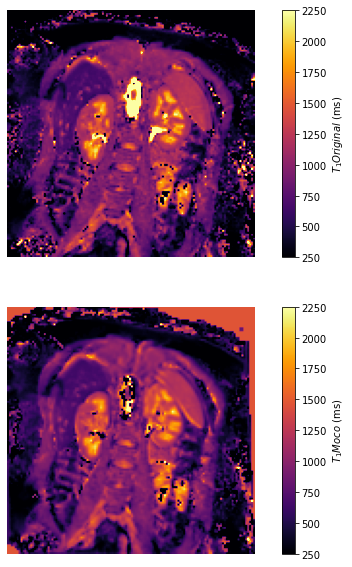

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Display the T1 map generated from the original data
im = ax1.imshow(np.rot90(t1_mapper.t1_map), cmap='inferno', clim=(250, 2250))
cb = fig.colorbar(im, ax=ax1)
cb.set_label('$T_1 Original$ (ms)')
ax1.axis('off')

# Display the T1 map generated from the motion corrected data
im2 = ax2.imshow(np.rot90(t1_moco_mapper.t1_map), cmap='inferno', clim=(250, 2250))
cb = fig.colorbar(im2, ax=ax2)
cb.set_label('$T_1 Moco$ (ms)')
ax2.axis('off')

plt.show()